In [31]:
%%capture
!git clone https://github.com/cuongtv312/marl-delivery.git
%cd marl-delivery
!pip install -r requirements.txt

In [32]:
from env import Environment
import gymnasium as gym
import numpy as np

In [33]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
wandb.login(key=wandb_api_key)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [34]:
def reward_shaping(reward, env, next_state, state, actions):
    shaped_reward = reward
    robots_before = state['robots']
    robots_after = next_state['robots']

    # Track newly picked up packages
    packages_carried_before = [r[2] for r in robots_before]
    packages_carried_after = [r[2] for r in robots_after]
    newly_picked_up = [p for p in packages_carried_after if p > 0 and p not in packages_carried_before]
    # Reward for each newly picked up package
    shaped_reward += 0.5 * len(newly_picked_up)

    # Convert robot positions to 0-indexed (environment uses 0-indexed internally)
    robot_positions_before = [(r[0]-1, r[1]-1, r[2]) for r in robots_before]
    robot_positions_after = [(r[0]-1, r[1]-1, r[2]) for r in robots_after]
    # Progress rewards for robots carrying packages
    for i, (pos_before, pos_after) in enumerate(zip(robot_positions_before, robot_positions_after)):
        pkg_id = pos_after[2]
        # Skip if not carrying anything
        if pkg_id == 0:
            continue
        # Find package target
        package = next((p for p in env.packages if p.package_id == pkg_id), None)
        if package:
            # If robot moved while carrying package
            if pos_before[:2] != pos_after[:2]:
                # Calculate distances to target
                old_dist = manhattan_distance(pos_before[:2], package.target)
                new_dist = manhattan_distance(pos_after[:2], package.target)
                # Reward progress toward target
                if new_dist < old_dist:
                    progress = (old_dist - new_dist) / (old_dist + 0.001)  # Normalized progress
                    shaped_reward += 0.1 * progress
                elif new_dist > old_dist:
                    shaped_reward -= 0.05  # Small penalty for moving away
                    
    # Urgency rewards - prioritize packages close to deadline
    for package in env.packages:
        if package.status == 'delivered':
            if env.t <= package.deadline:
                shaped_reward += 1.0
        elif package.status == 'waiting' and package.start_time <= env.t:
            time_left = package.deadline - env.t
            if time_left <= 5:  # Critical deadline
                # Find closest robot
                closest_dist = float('inf')
                for pos in robot_positions_after:
                    if pos[2] == 0:  # Only consider robots not carrying anything
                        dist = manhattan_distance(pos[:2], package.start)
                        closest_dist = min(closest_dist, dist)
                if closest_dist < float('inf'):
                    urgency_factor = max(0, (5 - time_left)) / 5
                    shaped_reward += 0.2 * urgency_factor / (closest_dist + 1)

    # Time pressure for waiting packages
    waiting_packages = sum(1 for p in env.packages if p.status == 'waiting' and p.start_time <= env.t)
    if waiting_packages > 0:
        shaped_reward -= 0.01 * waiting_packages
    return shaped_reward
    
def manhattan_distance(pos1, pos2):
    """Calculate Manhattan distance between two positions"""
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque, namedtuple
import random

# Experience tuple for replay buffer
Experience = namedtuple('Experience',
                        ['state', 'action', 'reward', 'next_state', 'done', 'agent_id'])

class ReplayBuffer:
    """Shared replay buffer for experience replay across agents"""
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, state, action, reward, next_state, done, agent_id):
        self.buffer.append(Experience(state, action, reward, next_state, done, agent_id))

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, min(batch_size, len(self.buffer)))

        states = [e.state for e in experiences]
        actions = [e.action for e in experiences]
        rewards = torch.tensor([e.reward for e in experiences], dtype=torch.float)
        next_states = [e.next_state for e in experiences]
        dones = torch.tensor([e.done for e in experiences], dtype=torch.float)
        agent_ids = [e.agent_id for e in experiences]

        return states, actions, rewards, next_states, dones, agent_ids

    def __len__(self):
        return len(self.buffer)

class ActorNetwork(nn.Module):
    """Actor network for policy approximation"""
    def __init__(self, state_size, action_size, hidden_size=64):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Separate outputs for movement and package actions
        self.move_head = nn.Linear(hidden_size, 5)  # 5 movement actions: S, L, R, U, D
        self.pkg_head = nn.Linear(hidden_size, 3)   # 3 package actions: 0, 1, 2

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        move_probs = F.softmax(self.move_head(x), dim=-1)
        pkg_probs = F.softmax(self.pkg_head(x), dim=-1)

        return move_probs, pkg_probs

class CriticNetwork(nn.Module):
    """Critic network for value function approximation"""
    def __init__(self, state_size, hidden_size=64):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Policy:
    """Individual agent using SEAC algorithm"""
    def __init__(self, state_size, action_size, agent_id, shared_buffer,
                 learning_rate=3e-4, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.agent_id = agent_id
        self.shared_buffer = shared_buffer
        self.gamma = gamma

        # Networks
        self.actor = ActorNetwork(state_size, action_size)
        self.critic = CriticNetwork(state_size)

        # Target networks (for stability)
        self.target_critic = CriticNetwork(state_size)
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=learning_rate)

        # For exploration
        self.eps = 0.1
        self.move_actions = ['S', 'L', 'R', 'U', 'D']
        self.pkg_actions = ['0', '1', '2']

        # Learning parameters
        self.tau = 0.01  # For soft target updates

    def get_action(self, state_tensor, explore=True):
        if state_tensor.shape[0] != self.state_size:
          diff = self.state_size - state_tensor.shape[0]
          if diff > 0:
            padding = torch.zeros(diff, dtype=state_tensor.dtype, device=state_tensor.device)
            state_tensor = torch.cat([state_tensor, padding])
          else:
            # print('Truncate state tensor')
            state_tensor = state_tensor[:self.state_tensor]
        with torch.no_grad():
            move_probs, pkg_probs = self.actor(state_tensor)

        # Epsilon-greedy exploration
        if explore and random.random() < self.eps:
            move_idx = random.randint(0, 4)  # Random movement action
            pkg_idx = random.randint(0, 2)   # Random package action
        else:
            move_idx = torch.argmax(move_probs).item()
            pkg_idx = torch.argmax(pkg_probs).item()

        return (self.move_actions[move_idx], self.pkg_actions[pkg_idx])

    def learn(self, robots_before, packages_before, batch_size=64):
        if len(self.shared_buffer) < batch_size:
            return

        states, actions, rewards, next_states, dones, _ = self.shared_buffer.sample(batch_size)
        
        # Convert states to tensors
        state_tensors = torch.stack([self._preprocess_state(s) for s in states])
        next_state_tensors = torch.stack([self._preprocess_state(s) for s in next_states])

        # Compute target values (TD target) using target network for stability
        with torch.no_grad():
            next_values = self.target_critic(next_state_tensors).squeeze()
            target_values = rewards + self.gamma * next_values * (1 - dones)

        # Compute current value estimates
        values = self.critic(state_tensors).squeeze()

        # Critic loss (MSE)
        critic_loss = F.mse_loss(values, target_values)

        # Actor loss
        # We need to process each experience individually for the actor loss
        actor_loss = 0
        entropy_loss = 0  # Add entropy to encourage exploration
        for i, (state, action) in enumerate(zip(state_tensors, actions)):
            move_action, pkg_action = action
            move_idx = self.move_actions.index(move_action)
            pkg_idx = int(pkg_action)

            move_probs, pkg_probs = self.actor(state)
            advantage = target_values[i] - values[i].detach()

            # Log probability of the taken actions
            log_prob_move = torch.log(move_probs[move_idx] + 1e-10)
            log_prob_pkg = torch.log(pkg_probs[pkg_idx] + 1e-10)

            # Policy gradient loss
            actor_loss -= (log_prob_move + log_prob_pkg) * advantage

            # Entropy loss to encourage exploration
            entropy_move = -torch.sum(move_probs * torch.log(move_probs + 1e-10))
            entropy_pkg = -torch.sum(pkg_probs * torch.log(pkg_probs + 1e-10))
            entropy_loss -= 0.01 * (entropy_move + entropy_pkg)  # Small entropy coefficient

        actor_loss = (actor_loss + entropy_loss) / len(states)

        # Update networks
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)  # Gradient clipping
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)  # Gradient clipping
        self.actor_optimizer.step()

        # Soft update target networks
        self._soft_update(self.critic, self.target_critic)

    def _soft_update(self, source, target):
        """Soft update: target = tau*source + (1 - tau)*target"""
        for target_param, source_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                self.tau * source_param.data + (1.0 - self.tau) * target_param.data
            )

    def _preprocess_state(self, state):
        """Convert environment state to tensor representation"""
        # Extract relevant information from state
        time_step = state['time_step']
        grid = state['map']
        robots = state['robots']
        packages = state.get('packages', [])

        # Flatten grid for simplicity
        flat_grid = [item for row in grid for item in row]

        # Extract robot features
        robot_info = []
        my_robot = None

        for robot_idx, (r, c, carrying) in enumerate(robots):
            if robot_idx == self.agent_id:
                my_robot = (r-1, c-1, carrying)  # Convert back to 0-indexed
            else:
                robot_info.extend([r-1, c-1, carrying])  # Convert back to 0-indexed

        # Ensure my_robot is at the beginning of the feature vector
        if my_robot:
            robot_info = [my_robot[0], my_robot[1], my_robot[2]] + robot_info

        # Extract package features - focus on active packages
        package_info = []
        for pkg_id, start_r, start_c, target_r, target_c, start_time, deadline in packages:
            # Only consider packages that are active now
            if start_time <= time_step:
                package_info.extend([start_r-1, start_c-1, target_r-1, target_c-1,
                                    deadline - time_step])  # Convert back to 0-indexed

        max_packages = PACKAGES
        while len(package_info) < max_packages * 5:
            package_info.extend([-1, -1, -1, -1, -1])  # Padding for non-existent packages

        # Combine all features
        features = [time_step] + robot_info + package_info

        return torch.tensor(features, dtype=torch.float)

class Agents:
    """Main SEAC algorithm implementation with shared experience"""
    def __init__(self):
        self.agents = []
        self.n_robots = 0
        self.state = None
        self.shared_buffer = ReplayBuffer(capacity=5000)  # Increased buffer size
        self.state_size = None  # Will be determined during initialization
        self.action_size = 8  # 5 movement actions * 3 package actions
        self.batch_size = 128  # Increased batch size for more stable learning
        self.update_frequency = 5  # Update networks every N steps
        self.step_counter = 0
        self.prev_states = {}
        self.prev_actions = {}
        self.prev_rewards = {}  # Track previous rewards for n-step returns
        self.training_mode = True  # Set to False for evaluation only
        self.training_stats = {
            'critic_losses': [],
            'actor_losses': [],
            'avg_values': [],
            'avg_advantages': []
        }  # For tracking training progress
        

    def init_agents(self, state):
        """Initialize SEAC agents"""
        self.state = state
        self.n_robots = len(state['robots'])
        self.map = state['map']

        # Calculate state size based on preprocessed state
        # This includes time step, all robot positions and carrying status, and package info
        # create a dummy agent to get the state size
        dummy_agent = Policy(0, self.action_size, 0, self.shared_buffer)
        dummy_state_tensor = dummy_agent._preprocess_state(state)
        self.state_size = len(dummy_state_tensor)

        # Create agents with correct state size
        self.agents = [Policy(self.state_size, self.action_size, i, self.shared_buffer)
                      for i in range(self.n_robots)]

        # Initialize previous states and actions
        for i in range(self.n_robots):
            self.prev_states[i] = None
            self.prev_actions[i] = None

    def get_actions(self, state):
        """Determine actions for all agents"""
        self.step_counter += 1
        actions = []
        robots_before = state['robots']
        packages_before = state['packages']
        
        for i, agent in enumerate(self.agents):
            # Preprocess state for the current agent
            state_tensor = agent._preprocess_state(state)

            # Get action from the agent's policy
            action = agent.get_action(state_tensor, explore=self.training_mode)
            actions.append(action)

            # Store experience if we have a previous state and action
            if self.training_mode and self.prev_states[i] is not None:
                # Get reward from environment (shared total reward for simplicity)
                # In a more sophisticated implementation, you might want to implement reward shaping
                # to better attribute rewards to individual agents
                reward = state.get('reward', 0)
                done = state.get('done', False)

                # Add experience to shared buffer
                self.shared_buffer.add(
                    self.prev_states[i],
                    self.prev_actions[i],
                    reward,
                    state,
                    done,
                    i
                )

            # Update previous state and action
            self.prev_states[i] = state
            self.prev_actions[i] = action

        # Update networks periodically
        if self.training_mode and self.step_counter % self.update_frequency == 0:
            for agent in self.agents:
                agent.learn(robots_before, packages_before, self.batch_size)
                
        return actions

In [43]:
def train(env, agents, num_episodes=1000, print_freq=10, save_path=None,
          initial_eps=0.3, final_eps=0.01, eps_decay_episodes=800, max_time_steps=100):
    # episode_rewards = []
    # best_avg_reward = float('-inf')
    original_rewards = []
    
    # Set initial epsilon for all agents
    for agent in agents.agents:
        agent.eps = initial_eps

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        agents.init_agents(state)

        # Reset experience tracking for new episode
        for i in range(agents.n_robots):
            agents.prev_states[i] = None
            agents.prev_actions[i] = None

        # Decay epsilon
        if episode <= eps_decay_episodes:
            current_eps = initial_eps - (initial_eps - final_eps) * (episode / eps_decay_episodes)
            for agent in agents.agents:
                agent.eps = current_eps

        # Run episode
        done = False
        # episode_reward = 0
        episode_org_reward = 0
        t = 0

        while not done:
            actions = agents.get_actions(state)
            next_state, reward, done, infos = env.step(actions)
            # shaped_reward = reward_shaping(reward, env, next_state, state, actions)
            
            # Add reward to state for experience collection
            # next_state['reward'] = shaped_reward
            next_state['done'] = done

            # Update state for next iteration
            state = next_state
            # episode_reward += shaped_reward
            episode_org_reward += reward
            t += 1

            # env.render
            # print("\n")
            
            if t == max_time_steps:
                break

        successful_deliveries = sum(1 for package in env.packages if package.status == 'delivered')
                
        original_rewards.append(episode_org_reward)
        # episode_rewards.append(episode_reward)

        if episode % print_freq == 0:
            # avg_reward = sum(episode_rewards[-print_freq:]) / print_freq
            avg_org_reward = sum(original_rewards[-print_freq:]) / print_freq
            print(f"Episode {episode}/{num_episodes}, "f"Avg Original Reward: {avg_org_reward:.2f}, "f"Epsilon: {agents.agents[0].eps:.3f}, "f"Buffer Size: {len(agents.shared_buffer)}")
            
        if wandb.run is not None:
            wandb.log({
                "episode": episode,
                # "reward per episode": episode_reward,
                "original reward per episode": episode_org_reward,
                "epsilon": agents.agents[0].eps,
                "buffer": len(agents.shared_buffer),
                "successful_deliveries per episode": successful_deliveries
            })

    return original_rewards

def evaluate(env, agents, num_episodes=10):

    # Disable exploration and training
    training_mode_backup = agents.training_mode
    agents.training_mode = False

    total_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            actions = agents.get_actions(state)
            next_state, reward, done, _ = env.step(actions)

            state = next_state
            episode_reward += reward

        total_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}/{num_episodes}, Reward: {episode_reward:.2f}")

    # Restore training mode
    agents.training_mode = training_mode_backup

    avg_reward = sum(total_rewards) / num_episodes
    print(f"Evaluation complete. Average Reward: {avg_reward:.2f}")
    return avg_reward

In [44]:
maps = {
    "map1": {"map_file": 'map1.txt',"max_time_steps": 100,'n_robots': 5, "n_packages": 40, 'seed': 10},
    "map2": {"map_file": 'map2.txt',"max_time_steps": 1000,'n_robots': 5, "n_packages": 100, 'seed': 10},
    "map3": {"map_file": 'map3.txt',"max_time_steps": 1000,'n_robots': 5, "n_packages": 500, 'seed': 10},
    "map4": {"map_file": 'map4.txt',"max_time_steps": 1000,'n_robots': 10, "n_packages": 500, 'seed': 10},
    "map5": {"map_file": 'map5.txt',"max_time_steps": 1000,'n_robots': 10, "n_packages": 100, 'seed': 10},
}

In [45]:
wandb_log = True
NUM_EPISODES = 100
EPS_DECAY = 50
INIT_EPS = 0.3
FINAL_EPS = 0.01

Starting training...
Episode 10/100, Avg Original Reward: -1.31, Epsilon: 0.242, Buffer Size: 4950
Episode 20/100, Avg Original Reward: 1.94, Epsilon: 0.184, Buffer Size: 5000
Episode 30/100, Avg Original Reward: -1.09, Epsilon: 0.126, Buffer Size: 5000
Episode 40/100, Avg Original Reward: -0.94, Epsilon: 0.068, Buffer Size: 5000
Episode 50/100, Avg Original Reward: -0.65, Epsilon: 0.010, Buffer Size: 5000
Episode 60/100, Avg Original Reward: 0.23, Epsilon: 0.100, Buffer Size: 5000
Episode 70/100, Avg Original Reward: -0.88, Epsilon: 0.100, Buffer Size: 5000
Episode 80/100, Avg Original Reward: 0.22, Epsilon: 0.100, Buffer Size: 5000
Episode 90/100, Avg Original Reward: -0.88, Epsilon: 0.100, Buffer Size: 5000
Episode 100/100, Avg Original Reward: -0.93, Epsilon: 0.100, Buffer Size: 5000


buffer,▅▆███████████████▁▃▅████████████████████
episode,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▇▇▇██▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▇█
epsilon,██▇▇▆▅▅▃▂▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃██▆▅▄▁▁▃▃▃▃▃▃▃▃
original reward per episode,▁▁▁▁▁▂▁▁▂█▁▂▂▂▁▁▁▂▁▁▁▁▁▁▂▂▁▂▁▁▂█▂▁▂▁▁▁▁▁
successful_deliveries per episode,▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
buffer,5000
episode,100
epsilon,0.1
original reward per episode,-1.1
successful_deliveries per episode,0


Text(0, 0.5, 'Episode Reward')

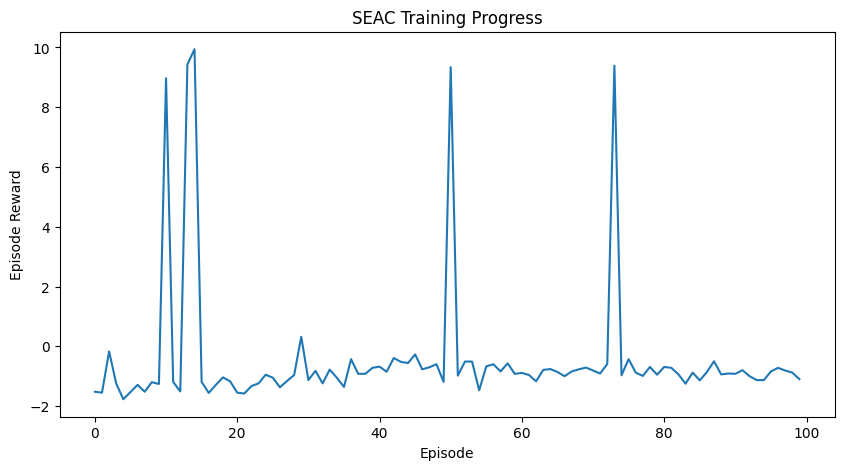

In [46]:
import os
import matplotlib.pyplot as plt
from multiprocessing import Process, Queue
import ray

selected = 'map1'
if selected == 'map1':
    PATH = maps[selected]['map_file']
    ROBOTS = maps[selected]['n_robots']
    PACKAGES = maps[selected]['n_packages']
    MAX_TIME_STEPS = 100
    SEED = 10
else:
    print('Using map1 config')
    PATH = 'map1.txt'
    ROBOTS = 2
    PACKAGES = 40
    MAX_TIME_STEPS = 100
    SEED = 10

env = Environment(map_file=PATH, max_time_steps=MAX_TIME_STEPS, n_robots=ROBOTS, n_packages=PACKAGES, seed=SEED)
# Initialize agents
state = env.reset()
agents = Agents()
agents.init_agents(state)

if wandb_log:
    wandb.init(project="MARL-pickup-and-delivery", name="SEAC", 
               tags = ['map1'],
               config={
                    "num_episodes": NUM_EPISODES,
                    "initial_eps": INIT_EPS,
                    "final_eps": FINAL_EPS,
                    "eps_decay_episodes": EPS_DECAY
               })

print("Starting training...")
episode_rewards = train(
    env,
    agents,
    num_episodes=NUM_EPISODES,
    print_freq=10,
    initial_eps=INIT_EPS,
    final_eps=FINAL_EPS,
    eps_decay_episodes=EPS_DECAY,
    max_time_steps=MAX_TIME_STEPS
)

if wandb.run is not None:
    wandb.finish()

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards)
plt.title('SEAC Training Progress')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

In [47]:
agents.training_mode = False
for agent in agents.agents:
    agent.eps = 0.0
for agent in agents.agents:
    agent.actor.eval()
done = False
state = env.reset()
t = 0
reward_history = []
while not done:
    actions = agents.get_actions(state) 
    state, reward, done, infos = env.step(actions)

    print("\nState after step:")
    env.render()
    print(f"Reward: {reward}, Done: {done}, Infos: {infos}")
    print("Time step:", env.t)
    print("Packages:", state['packages'])
    print("Robots:", state['robots'])
    reward_history.append(env.total_reward)
    # For debug purpose
    t += 1
    if t == 100:
        break


State after step:
1	1	1	1	1	1	1	1	1	1
1	0	0	0	0	0	R3	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	R0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	R2	0	0	0	0	1
1	R1	0	0	0	0	0	0	0	1
1	0	0	0	0	0	R4	0	0	1
1	1	1	1	1	1	1	1	1	1
Reward: -0.03, Done: False, Infos: {}
Time step: 1
Packages: []
Robots: [(5, 7, 0), (8, 2, 0), (7, 5, 0), (2, 7, 0), (9, 7, 0)]

State after step:
1	1	1	1	1	1	1	1	1	1
1	0	0	0	0	0	R3	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	R0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	R2	0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	R1	0	0	0	R4	0	0	0	1
1	1	1	1	1	1	1	1	1	1
Reward: -0.03, Done: False, Infos: {}
Time step: 2
Packages: []
Robots: [(5, 7, 0), (9, 2, 0), (7, 6, 0), (2, 7, 0), (9, 6, 0)]

State after step:
1	1	1	1	1	1	1	1	1	1
1	0	0	0	0	0	R3	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	R0	0	0	1
1	0	0	0	0	0	0	0	0	1
1	0	0	0	0	0	R2	0	0	1
1	0	0	0	0	0	0	0	0	1
1	R1	0	0	R4	0	0	0	0	1
1	1	1	1	1	1	1	1	1	1
Reward: -0.02, Done: False, Infos: {}
Time step: 3
Packages: [(7, 9, 6, 

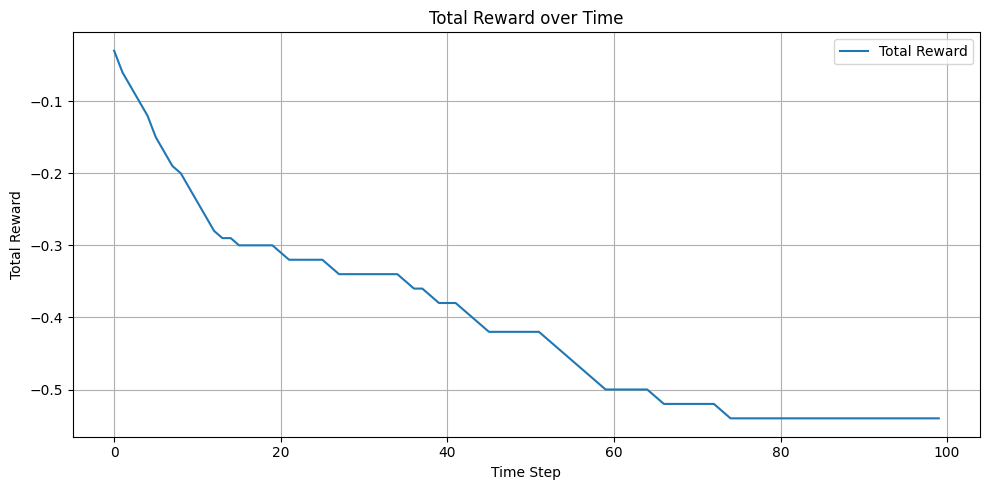

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(reward_history, label="Total Reward")
plt.xlabel("Time Step")
plt.ylabel("Total Reward")
plt.title("Total Reward over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()